In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
from tqdm import tqdm
import trackml.dataset

In [4]:
import torch
import pytorch_lightning as pl
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import itertools

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
sys.path.append('..')
from src.drawing import detector_layout, draw_proc_event
from src.utils_math import polar_to_cartesian

### Testing Colors

In [7]:
from matplotlib import cm

In [29]:
cmap = cm.get_cmap('gnuplot')

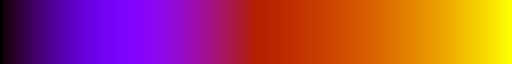

In [30]:
cmap

In [87]:
cmap.N

256

In [32]:
cmap.name

'gnuplot'

In [83]:
NUM_COLORS = 15
color_list = [cmap(i) for i in np.linspace(0, 1, NUM_COLORS)]

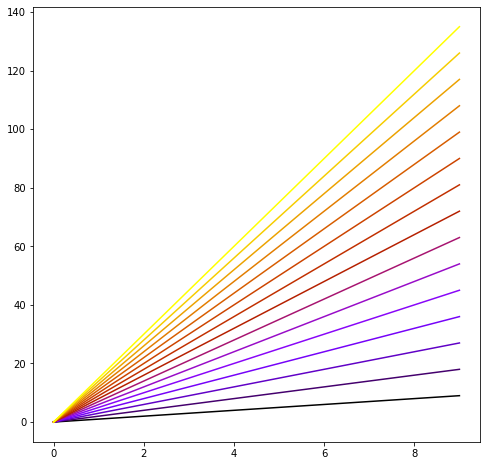

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
plt.gca().set_prop_cycle('color', color_list)
for i in range(NUM_COLORS):
    ax.plot(np.arange(10)*(i+1))

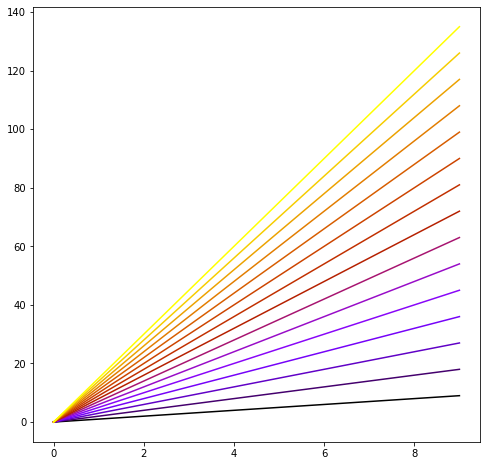

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
for i in range(NUM_COLORS):
    ax.plot(np.arange(10)*(i+1), color=color_list[i])

## _(A.) Adjust the Epsilon_

Lets lowere the `epsilon_cut=0.25`.

In [53]:
# The Good Event
e_id = 5015
event_idx = 5015%500

In [54]:
# trkx_from_gnn.sh <epsilon_cut> <max_events>
# !./eval_one_evt.sh $e_id 0.20 100

## _(B.) Inspection on Track Crossing_

- lets plot two reconstructed events, one is `clean` and the other a little `complex`
- see an event with duplicated tracks, find out why they are duplicated.

In [55]:
with open("run/trkx_reco_eval/{}_summary.txt".format(e_id)) as f:
    contents = f.read()
    print(contents)

--------------------------------------------------
Run Time:      20220620-141851
Reconstructed tracks: /home/adeak977/current/3_deeptrkx/ctd2022/eval/run/trkx_from_gnn
# of events: 1
Truth tracks:                   10
Truth tracks matched:                   10
Reco. tracks:                   12
Reco. tracks matched:                   12
Reco. tracks matched to POI:                   12
Reco. tracks duplicated:                    2
Tracking Eff.:             100.0000%
Fake rate:                   0.0000%
Duplication Rate:              16.6667%



In [56]:
# true tracks (test dataset)
inputdir="run/gnn_evaluation/test"
true_trkx = sorted(glob.glob(os.path.join(inputdir, "*")))

In [57]:
# reco tracks (track candidates)
inputdir="run/trkx_from_gnn"
reco_trkx = sorted(glob.glob(os.path.join(inputdir, "*")))

### _(1.) - Plot True Event_

In [58]:
# true events
true_event = torch.load(true_trkx[event_idx], map_location=device)

# hit features
r, phi, ir = true_event.x.T

# spatial coordinate transform
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

# compensate scaling
ir = ir.detach().numpy()*100

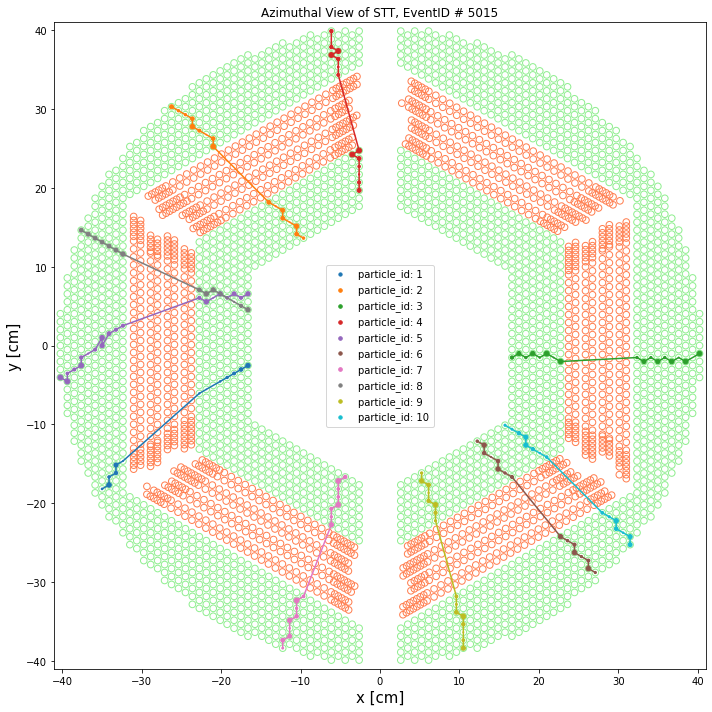

In [89]:
# plot true event
fig, ax = detector_layout(figsize=(10,10))

e_id = int(true_event.event_file[-4:])
p_ids = np.unique(true_event.pid)

for pid in p_ids:
    idx = true_event.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(int(pid)))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("{}_complex_true.png".format(e_id))

### _(2.) - Plot Reco Event_

In [22]:
# lets plot reconstructed true event, i.e. event = 96
reco_event = torch.load(reco_trkx[event_idx], map_location=device)

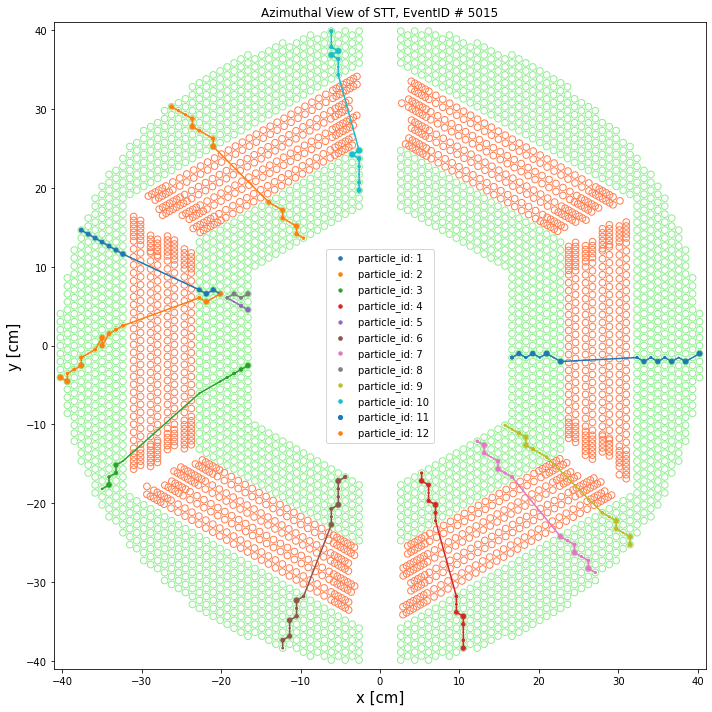

In [90]:
# plot reco event, here, (x,y,ir) comes from ture event. but idx is from reco event
fig, ax = detector_layout(figsize=(10,10))

e_id = e_id
t_ids = np.unique(reco_event.track_id)
for tid in t_ids:
    idx = reco_event.track_id == tid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(tid+1))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("{}_complex_reco.png".format(e_id))

In [24]:
dup_hids = reco_event.query("track_id==-1")["hit_id"]

In [25]:
dup_hids.values

array([], dtype=int32)

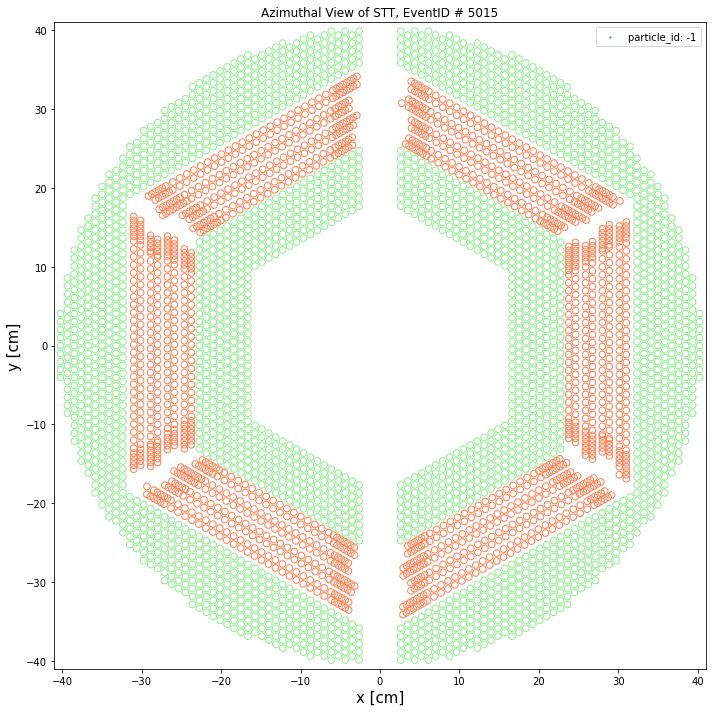

In [26]:
# lets plot the duplicated hits
fig, ax = detector_layout(figsize=(10,10))
e_id = e_id

tid = -1
idx = reco_event.track_id == tid
ax.plot(x[idx], y[idx], '-', linewidth=0.5)
ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()